# Group Project Report: Maternal Health Risk Classification

Members: Ruby Liu, Yu Wei Chen, Annabel Lim, Heather Jia

## 1. Introduction

### Background Information

Depending on a number of factors, a pregnancy can be considered “high-risk”. A high-risk pregnancy means that both mother and child are more likely to have health problems, requiring special monitoring to ensure the least amount of harm. It is important to know whether a mother is high-risk, so medical professionals can take the necessary preventative measures to ensure the health of both the mother and baby. 

### Project Question

Can we use the maternal risk factor measurements (age, systolic blood pressure, diastolic blood pressure, and blood sugar level) provided in our data to predict whether someone who is pregnant is at high-risk, mid-risk, or low-risk of maternal mortality? 

### Data Set

We will be using the Maternal Health Risk Data Set from the UCI Machine Learning Repository. The data was collected from hospitals, community clinics, and maternal health care centres from the rural areas of Bangladesh where region-specific studies have found that 1 in 10 pregnant women have low blood glucose levels. There are columns for age, systolic blood pressure, diastolic blood pressure, blood sugar, body temperature, heart rate, and risk level.


## 2. Methods and Results 

First, we load the libraries needed to perform our data analysis and set the seed value for randomness and reproducibility. Then to read the data from the web in R, we used the URL linked to the data set with the `read_csv` function, since the data set is a .csv file. We used the `mutate` with the `as_factor` function to convert the categorical variable `RiskLevel` from a character to a factor.

In [1]:
# installing necessary packages on UBC Jupyter Open due to issues with the DSCI 100 Jupter server
install.packages("tidymodels")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# load libraries 
library(tidyverse)
library(tidymodels)

# set seed value
set.seed(4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

Warni

In [3]:
# data set url
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00639/Maternal%20Health%20Risk%20Data%20Set.csv"

# read data 
maternity_data <- read_csv(url) |>
    mutate(RiskLevel = as_factor(RiskLevel))
head(maternity_data)

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,130,80,15.00,98,86,high risk
35,140,90,13.00,98,70,high risk
29,90,70,8.00,100,80,high risk
30,140,85,7.00,98,70,high risk
35,120,60,6.10,98,76,low risk
23,140,80,7.01,98,70,high risk


For our classification algorithm, we chose to use only age, blood sugar levels, diastolic and systolic blood pressure as our predictive variables from the data set. We achieved this by using the `select` function. 

In [4]:
# keep predictors: Age, Systolic Blood Pressure, Diastolic Blood Pressure, Blood Sugar
# target variable: Risk Level 
maternity_selected <- maternity_data |>
    select(Age, DiastolicBP, SystolicBP, BS, RiskLevel)
head(maternity_selected)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
29,70,90,8.00,high risk
30,85,140,7.00,high risk
35,60,120,6.10,low risk
23,80,140,7.01,high risk


Next, we split the data into training and testing sets, using 75% of the data for training and 25% for testing. This is done to evaluate the accuracy of the classifier using cross-validation. The more predictions that match the observations in the test set, the more accurate the classifier. 

In [5]:
# setting the seed
set.seed(4);

# split data by 75% training, 25% testing 
maternity_split <- initial_split(maternity_selected, prop = 0.75, strata = RiskLevel) 

# training set 
maternity_train <- training(maternity_split)

# testing set
maternity_test <- testing(maternity_split)

head(maternity_train)
head(maternity_test)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
30,85,140,7.00,high risk
23,80,140,7.01,high risk
50,90,140,15.00,high risk
25,100,140,7.01,high risk


Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,70,90,8.00,high risk
23,70,130,7.01,mid risk
35,60,85,11.00,high risk
42,80,130,18.00,high risk
50,80,140,6.70,mid risk
21,65,90,7.50,low risk


In [6]:
# find proportions of labels
maternity_proportions <- maternity_train |>
    group_by(RiskLevel) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(maternity_train))

maternity_proportions

RiskLevel,n,percent
<fct>,<int>,<dbl>
high risk,204,26.84211
low risk,304,40.00000
mid risk,252,33.15789


##### *Table 1.* Proportions of target variable labels 

To further explore our data, Table 1 is created to find the proportions of each risk level in the training data set. This can help us identify any biases that may occur. Table 1 indicates to us that the proportions of the target variable are not proportional, which will be resolved in a later function function's argument (`vfold_cv`'s `strata` argument).

In [7]:
# find mean of each predictor
maternity_predictor_means <- maternity_train |>
    select(- RiskLevel) |>
    map_df(mean)

maternity_predictor_means

Age,DiastolicBP,SystolicBP,BS
<dbl>,<dbl>,<dbl>,<dbl>
29.95658,76.63684,113.1776,8.807539


##### *Table 2.* Average of each predictor

To aid with our understanding of the data set, the mean of each predictor was calculated, as shown in Table 2. Below, we create visualizations of the data set in Figures 1, 2, and 3 to further our understanding. 

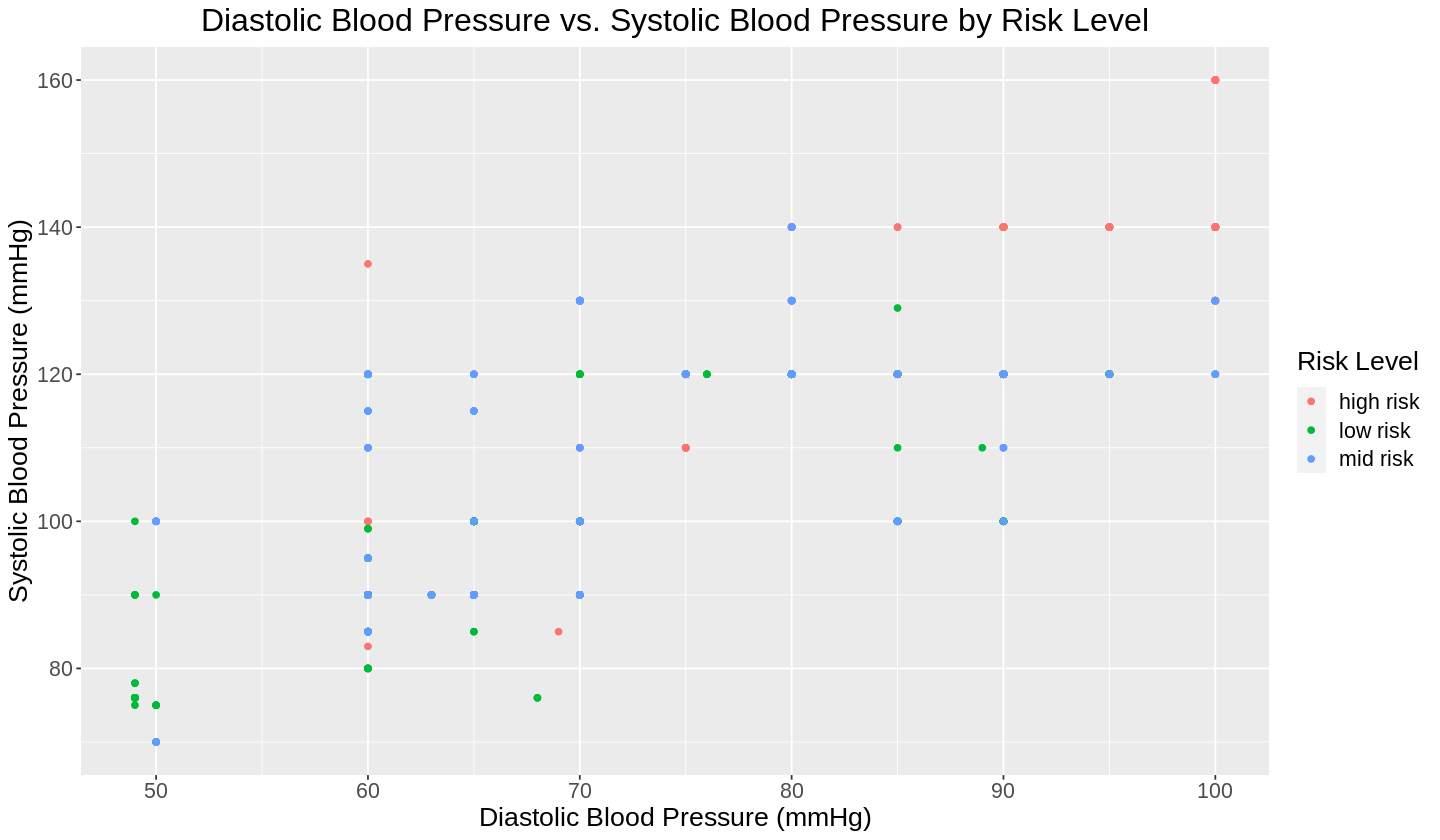

In [8]:
# setting plot dimensions
options(repr.plot.width = 12, repr.plot.height = 7)

# plot diastolic BP vs systolic BP, color by risk level
maternity_diastolic_vs_systolic <- maternity_train |>
    ggplot(aes(x = DiastolicBP, y = SystolicBP, color = RiskLevel)) +
        geom_point() +
        labs (x = "Diastolic Blood Pressure (mmHg)", y = "Systolic Blood Pressure (mmHg)", color = "Risk Level") +
        ggtitle("Diastolic Blood Pressure vs. Systolic Blood Pressure by Risk Level") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_diastolic_vs_systolic

##### *Figure 1.* Preliminary exploratory data analysis: Diastolic Blood Pressure vs. Systolic Blood Pressure by Risk Level

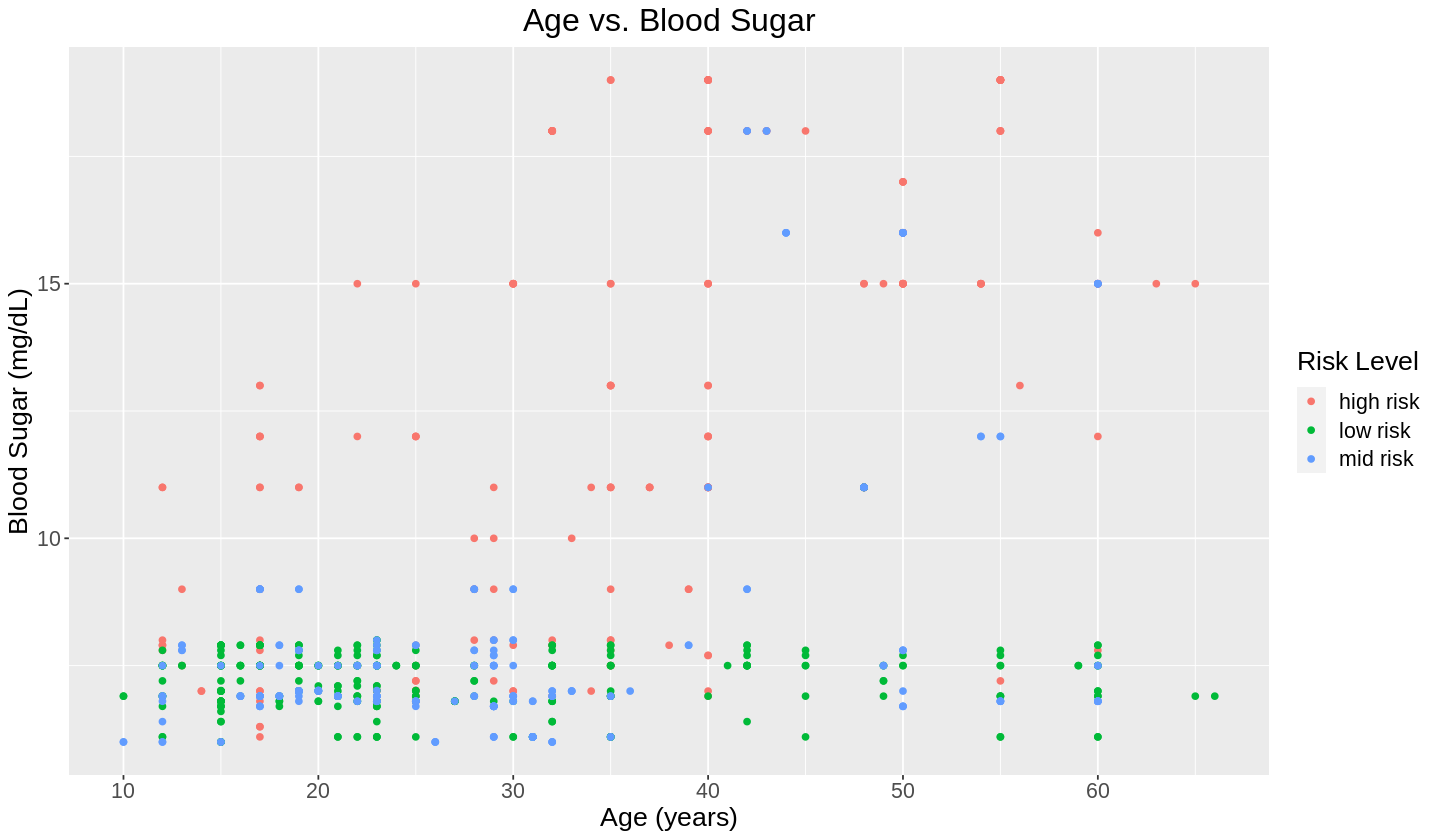

In [9]:
# plot blood sugar vs age, colour by risk level
maternity_BS_vs_Age <- maternity_train |>
    ggplot(aes(x = Age, y = BS, color = RiskLevel)) +
        geom_point() +
        labs (x = "Age (years)", y = "Blood Sugar (mg/dL)", color = "Risk Level") +
        ggtitle("Age vs. Blood Sugar") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_BS_vs_Age

##### *Figure 2.* Preliminary exploratory data analysis: Age vs. Blood Sugar

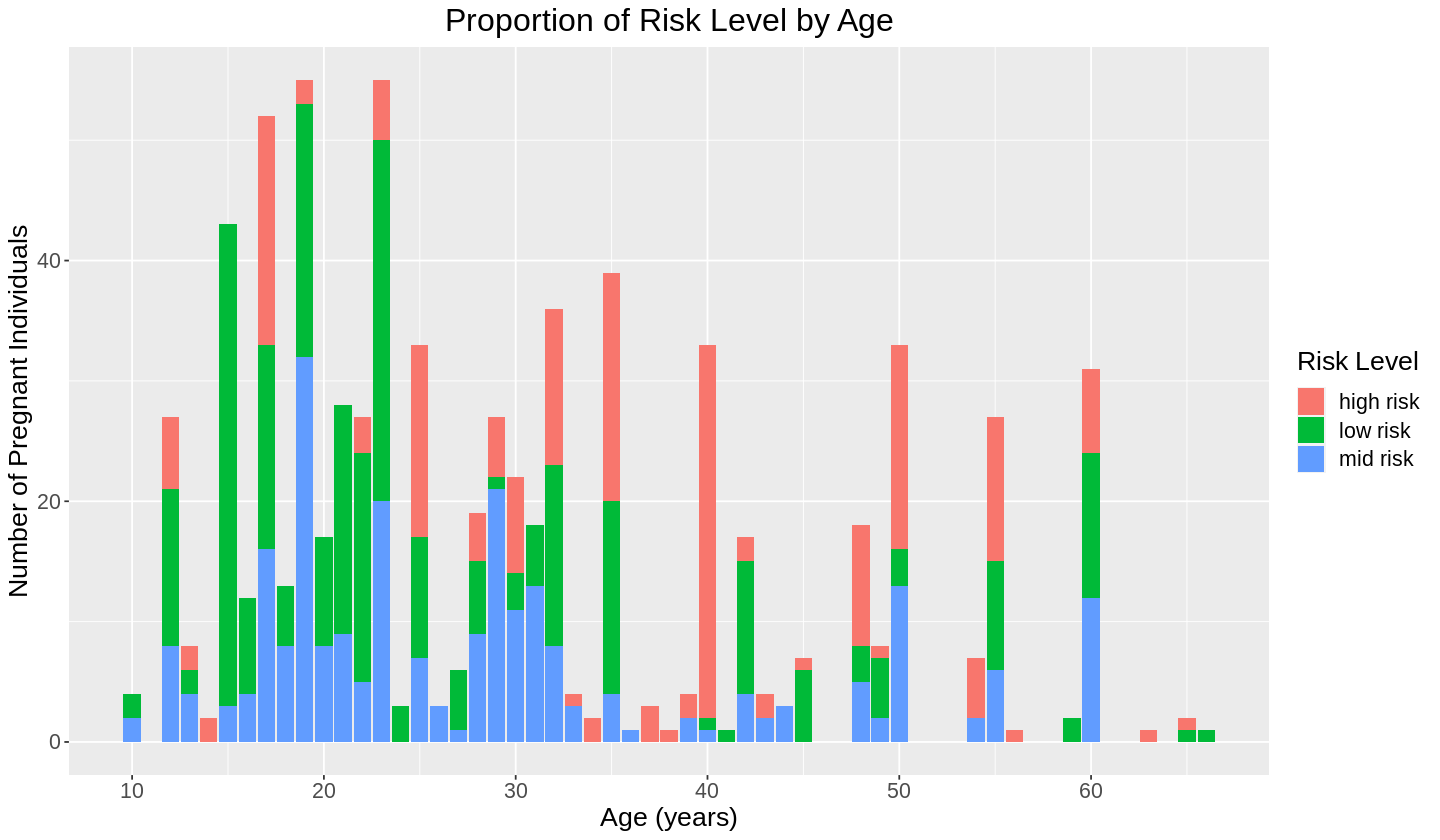

In [10]:
# plot proportion of risk level based on age 
maternity_age_vs_risk <- maternity_train |>
    ggplot(aes(x = Age, fill = RiskLevel)) +
        geom_bar() +
        labs(x = "Age (years)", y = "Number of Pregnant Individuals", fill = "Risk Level") +
        ggtitle("Proportion of Risk Level by Age") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_age_vs_risk

##### *Figure 3.* Preliminary exploratory data analysis: Proportion of Risk Level by Age

To continue building our classifier, we create a recipe, which holds the steps we want to apply to our training set to prepare it for data pre-processing. Within the recipe, we specify that the target variable column is `RiskLevel` and that the predictors are all columns except for `RiskLevel`. We also pass our unscaled training data set as the data argument. As we are using the $k$-nearest neighbours algorithm, we need to ensure all data observations are on a comparable scale and contributed equal shares to the calculation of the distance between points. We achieve this by adding the `step_scale` and `step_center` steps to our recipe.

Next, we create a KNN model specification with the `nearest_neighbors` function. We set `weight_func` as “rectangular” so that each K nearest neighbor gets exactly 1 vote and `neighbors` as `tune()` so that each parameter in the model is tuned. We then pipe this model object to `set_engine(“kknn”)` to specify that we are using the `kknn` package to train our model, followed by `set_mode(“classification”)` to specify that this is a classification problem. 

Then to perform a 5-fold cross validation on the training set, we first split training data into 5 folds, setting `strata` to `RiskLevel` to ensure that the training and validation subsets contain the right proportions of each category in `RiskLevel`. 

In [11]:
# setting the seed
set.seed(4)

# create recipe with all predictors
maternity_recipe <- recipe(RiskLevel ~., data = maternity_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform 5 fold cross validation on training set
train_vfold <- vfold_cv(maternity_train, v = 5, strata = RiskLevel) 

We then create a tibble with $k$ values from 1 to 10, which are the values of parameter $k$ that we want to try. Using the `workflow` function, we combined the recipe and model specifications and applied cross validation with the `fit_resamples` function. To run cross validation on each train and validation split, we pass in the 5-folded data set and the $k$ values tibble into the `tune_grid` function to tune the model for each value of $k$. The fitted model is then passed into the `collect_metrics` function to get its metrics data, focusing on accuracy.

In [12]:
# create data frame where k = 1 to 10
k_vals <- tibble(neighbors = seq(from = 1, to = 10))

# use workflow to combine recipe + model spec
# then tune model using tune_grid and collect metrics
knn_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = train_vfold, grid = k_vals) |>
    collect_metrics()

# get accuracy from metrics on fitted model 
accuracies <- knn_results |>
    filter(.metric == "accuracy")

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7750320,5,0.007321992,Preprocessor1_Model01
2,accuracy,multiclass,0.7671713,5,0.007404737,Preprocessor1_Model02
3,accuracy,multiclass,0.6974668,5,0.016865842,Preprocessor1_Model03
4,accuracy,multiclass,0.6895889,5,0.014350892,Preprocessor1_Model04
5,accuracy,multiclass,0.6619216,5,0.021355788,Preprocessor1_Model05
6,accuracy,multiclass,0.6592724,5,0.018257172,Preprocessor1_Model06


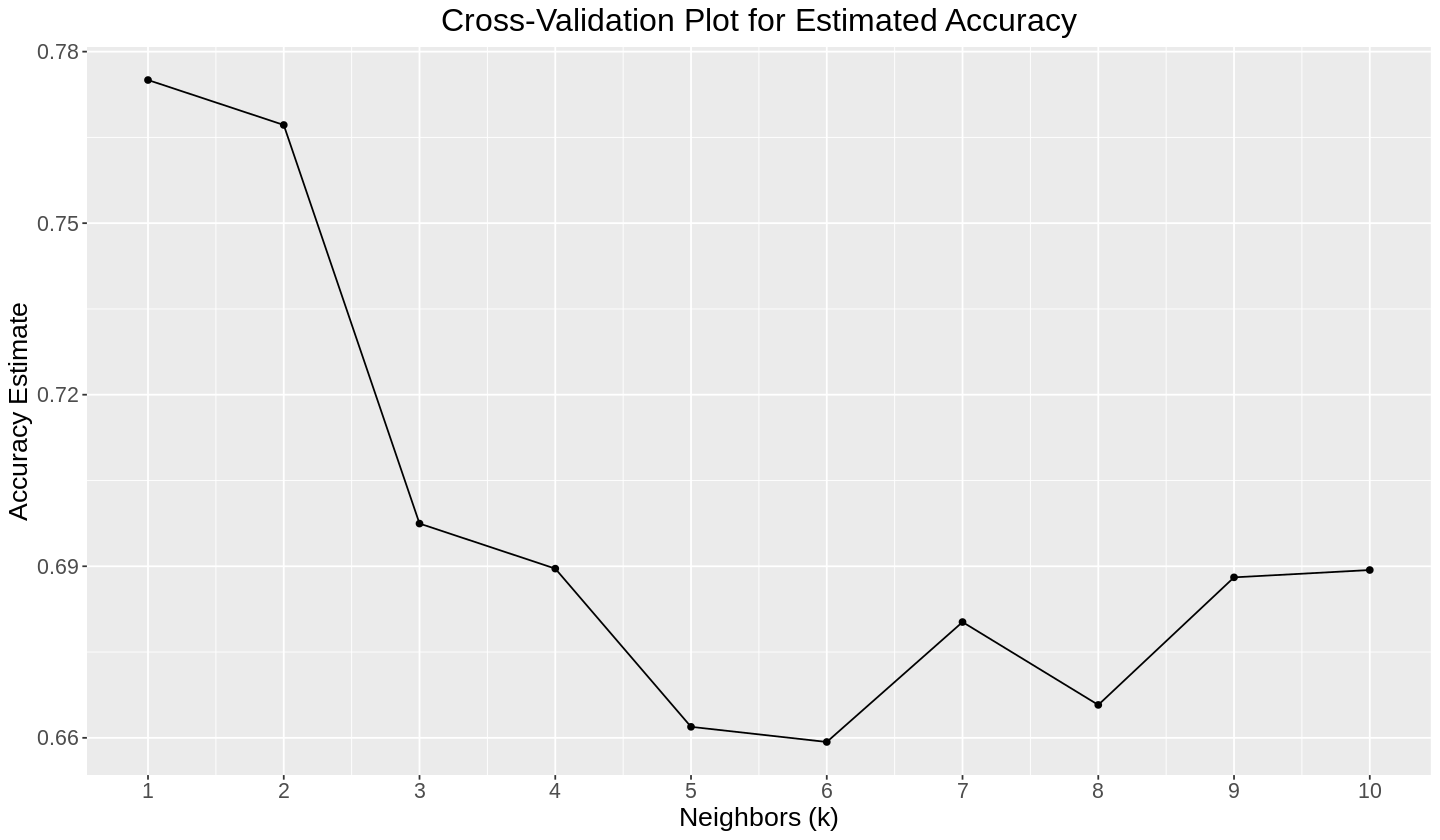

In [13]:
# plot k (neighbors) vs accuracy (mean)
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
        ggtitle("Cross-Validation Plot for Estimated Accuracy") +
        scale_x_continuous(breaks = 1:10) +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

# using the plot can make deciding which k value may be the best easier
cross_val_plot

##### *Figure 4.* Cross-Validation Plot for Estimated Accuracy

To facilitate the $k$ selection process, we plotted a line graph of accuracy versus each $k$ value with the accuracy data of our fitted model. We then picked the best $k$ value with the highest estimated accuracy for our classification algorithm. As seen in Figure 4, our most accurate $k$ value (excluding $k$ = 1) is $k$ = 2. 

Finally, we create another model specification with our selected $k$ value to start building the final version of our model. We made sure to use the `fit` function to fit the model with our selected $k$ value. To predict the class labels of `RiskLevel` in our test set, we pipe our fitted model into the `predict` function with the test data set. Then we pass our predicted object to the `bind_cols` function to add a predictions column to compare with our original, non-fitted test data set.

In [14]:
# choose k = 2

# create knn model specification with chosen k
final_spec <- nearest_neighbor(weight_func = "rectangular",
                               neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

# analysis
final_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(final_spec) |>
    fit(data = maternity_train) |>
    predict(maternity_test) |>
    bind_cols(maternity_test)

We then extract the final model's accuracy by comparing the true label from the `RiskLevel` column to the predicted label from the `.pred_class` column, as seen in Table 3. 

In [15]:
# extracting model's accuracy
final_accuracy <- final_results |>
    metrics(truth = RiskLevel, estimate = .pred_class) |>
    filter(.metric == "accuracy")

final_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8307087


##### *Table 3.* Accuracy of final retrained classifier model

A confusion matrix is then created to see how many labels the final retrained model correctly predicted and where the mistakes were happening. From Table 4, we can see the mistakes the classifier made in regard to false negative, and false positives, which will help us determine how accurate our classifier is. 

In [16]:
# extracting model's confusion matrix
final_conf_mat <- final_results |>
    conf_mat(truth = RiskLevel, estimate = .pred_class)

final_conf_mat

           Truth
Prediction  high risk low risk mid risk
  high risk        61        2        5
  low risk          1       88       17
  mid risk          6       12       62

##### *Table 4.* Confusion matrix of model's accuracy

## 3. Discussion

### Summary of findings

Based on the results of tuning our classifier seen in Figure 4, the best choice of $k$ was 2 neighbours since it had the highest estimated accuracy (76.7%) compared to other $k$ values that were tested other than $k$ = 1 nearest neighbour (which is not a good choice despite a having a slightly higher accuracy of 77.5%). The final accuracy of our retrained model showed an increase of ~6% from the estimation to 83.1%, which is not bad.  The accuracy from our cross validation plot is an estimation of the accuracy while the accuracy from our final model is not an estimation, which explains the difference in accuracy. Also, we can see from the confusion matrix (Table 4) that the model performed relatively better on classifying high-risk and low-risk cases, while mid-risk cases had the most false positives. 

### Expectations of findings

Our classifier having more false positives relating to mid risk was expected to an extent due to it being a sort of “middle ground”. As most classifiers work with two labels (for example, high-risk and low-risk), there would be less potential for overlapping false labels in a good model. However, since we had mid-risk to consider as well, the predictor values of low-risk observations and mid-risk observations may have been similar, resulting in the classifier mislabeling many low-risk and mid-risk observations seen in the testing set.

The main thing that we did not expect to find was our final choice of $k$ = 2. The problem with this value is that it is a low, even number, which is not ideal for the $k$-nearest neighbours algorithm which should perform best when $k$ is an odd number since a predicted label is determined based on the label of the majority of an observation’s neighbours. An even number is more problematic when any number of possible labels are evenly distributed. Another unexpected result related to choosing $k$ was the trend in our line graph for the cross-validation plot. It did not resemble any examples that we had seen previously. One other thing that we did not expect to see was a noticeable difference between the estimated accuracy versus the final accuracy of the retrained model. 

### Impact of findings

While the accuracy of our model is not horrible, a higher accuracy should be required for a predictive algorithm of this nature to be applied in real-life scenarios. With our model, 17% of all cases would be inaccurately classified. If this model is applied to a large population, many lives could be negatively impacted if riskier cases are not identified.

As there is a smaller chance of mistaking high-risk labeled patients for other risk levels, when evaluating the health of pregnant women where the model predicted high-risk, we can use this prediction as an indicator that they most likely are at high-risk. However, if the model were to predict mid- or low-risk, further testing regarding the health of the baby and mother may be needed to confirm if they are really at mid-risk or low-risk of complications. Taking this approach is best for ensuring good maternal health from a moral standpoint. However, if we were to go forward with using a predictive model like ours to classify maternal health risk with this approach, further testing as described might not be sustainable long-term when considering resources necessary for confirming risk level. 

### Potential future questions

#### Question 1

As our data set is based on rural areas of Bangladesh, how different will the values of the predictor variables be for pregnant women in non-rural areas of Bangladesh and/or North America? How much would this difference influence the accuracy of our model, specifically to reduce the number of mistakes made between classifications of mid-risk and low-risk? The difference in values for predictor variables might not be that different as there is only so much range a group of people can have in something like blood pressure until it is obviously abnormal. However, the proportions of risk levels between rural and non-rural data are likely to indicate the state of healthcare in those areas.

#### Question 2

With artificial intelligence being combined with ultrasound images, can an improvement of the model, with a higher accuracy and trained on more diverse data, be used as a cheaper, safer, more accessible, and efficient alternative to detect pregnancy risks? In countries that have less accessible health care facilities, such a model could be added to a small machine then carried around by nurses or practitioners in these areas. There would be no need to carry around a big ultrasound machine or have many of these expensive machines around. Then if the classifier were to detect a high-risk, that individual could be taken to a hospital for further testing. 

#### Question 3

Will society trust artificial intelligence to determine if a mother and their child is at risk during pregnancy? A lot of people still dislike AI and do not like it being combined with health related fields. For instance, if the classifier were to predict a high-risk, it may influence the mother to think differently about the child they are carrying. With this in mind, we could be putting the decision of the birth or death of a fetus in the hands of AI. On the other hand, because AI has the ability to process and train on so much more data (different cases of high-, mid-, and low-risk pregnancies), the AI has seen more diverse cases than any doctor has, hence should be more accurate. These different perspectives may cause a dispute if we were to solely use such a classifier to diagnose the risk of a pregnancy. 

## 4. References 

- *Maternal Health Risk Data Set Data Set*. (2020, December 31). UCI Machine Learning Repository. Retrieved March 12, 2023, from https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set
- Mondal, R., Sarkar, N., Karim, A. I., Numan, S. M., & Zaman, M. (2022). Pregnancy-related health status in a remote rural area of Bangladesh: results from a clinic-based cross-section of antenatal check-up visits. *Journal of Xiangya Medicine, 7*, 0. https://doi.org/10.21037/jxym-21-36
- World Health Organization: WHO. (2023, February 22). *Maternal mortality*. World Health Organization. Retrieved March 12, 2023, from https://www.who.int/news-room/fact-sheets/detail/maternal-mortality